In [2]:
import keras_tuner as kt

import pandas as pd
import numpy as np
import random

import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.utils import plot_model
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler,StandardScaler,OneHotEncoder,OrdinalEncoder

SEED_VALUE=123
random.seed(SEED_VALUE) 
np.random.seed(SEED_VALUE)

In [3]:
print('num Device: ',len(tf.config.experimental.list_physical_devices()))
print(tf.config.experimental.list_physical_devices())

num Device:  2
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# READING DATA

In [4]:
df = pd.read_csv('diabetes_prediction_dataset.csv') 
df.head() 

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


# Preprocessing

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


In [6]:
df.shape

(100000, 9)

#### dari info diatas, bisa dilihat dari total 100000 entries, tidak ada sama sekali kolom yang mengandung null values 

In [7]:
df.duplicated().sum() 

3854

In [8]:
df.drop_duplicates(inplace=True) 
df.duplicated().sum() 

0

### Split Columns

In [9]:
num_cols = []
cat_cols = [] 
 
for col in df.columns: 
    if df[col].dtype == 'object': 
        cat_cols.append(col)
    else:
        num_cols.append(col)

In [10]:
#hypertension dan heart_disease itu merupakan kolom yang sudah di encode, yang berarti merupakan sebuah categorical data, maka dari itu ditambahkan ke cat_cols
cat_cols.extend(['hypertension', 'heart_disease'])
for col in ['hypertension', 'heart_disease']: 
    num_cols.remove(col)

In [11]:
print(num_cols)
print(cat_cols)

['age', 'bmi', 'HbA1c_level', 'blood_glucose_level', 'diabetes']
['gender', 'smoking_history', 'hypertension', 'heart_disease']


##### cek unique kolom kategorik

In [12]:
for col in cat_cols:
    print(df[col].unique()) #cari unique value, supaya kalo misalkan ada Typo atau inkonsistensi dalam penamaan value, bisa di-replace

['Female' 'Male' 'Other']
['never' 'No Info' 'current' 'former' 'ever' 'not current']
[0 1]
[1 0]


##### disini saya asumsikan bahwa ever dan not current adalah bagian dari former

In [13]:
#looping untuk me-replace ever dan not current dengan former
for i in ['ever', 'not current']:
    df['smoking_history'] = df['smoking_history'].replace({'ever': 'former', 'not current': 'former'}) 

In [14]:
df['smoking_history'].value_counts() 

smoking_history
never      34398
No Info    32887
former     19664
current     9197
Name: count, dtype: int64

### Splitting Features and Target

In [15]:
x = df.drop(['diabetes'],axis=1) 
y = df['diabetes']

In [16]:
x

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level
0,Female,80.0,0,1,never,25.19,6.6,140
1,Female,54.0,0,0,No Info,27.32,6.6,80
2,Male,28.0,0,0,never,27.32,5.7,158
3,Female,36.0,0,0,current,23.45,5.0,155
4,Male,76.0,1,1,current,20.14,4.8,155
...,...,...,...,...,...,...,...,...
99994,Female,36.0,0,0,No Info,24.60,4.8,145
99996,Female,2.0,0,0,No Info,17.37,6.5,100
99997,Male,66.0,0,0,former,27.83,5.7,155
99998,Female,24.0,0,0,never,35.42,4.0,100


In [17]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: diabetes, dtype: int64

In [18]:
class_distribution = y.value_counts() 
print(class_distribution)

#bisa terlihat bahwa distribusinya tidak merata / imbalance, dimana orang yang tidak diabetes lebih banyak

diabetes
0    87664
1     8482
Name: count, dtype: int64


# Split Train, Test, Validation data

In [19]:
x_train,x_test,y_train,y_test = train_test_split(x,y, test_size = 0.2,random_state = SEED_VALUE)

x_train,x_val,y_train,y_val = train_test_split(x_train,y_train, test_size = 0.25,random_state = SEED_VALUE) 
print(x_train.shape,y_train.shape)
print(x_val.shape,y_val.shape)
print(x_test.shape,y_test.shape)

(57687, 8) (57687,)
(19229, 8) (19229,)
(19230, 8) (19230,)


##### setelah split train test dan val data, sekarang saya ingin melakukan preprocessing lebih lanjut yaitu encoding & scaling

In [20]:
#menggunakan ohe encoding karena valuenya itu lumayan banyak sekitar 3-4 dan tidak berurutan (ordinal) sehingga OHE pilihan yang tepat
ohe_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore') 
ohe_cols = ['gender', 'smoking_history']  # Hanya encode kolom ini

new_cat_cols = ohe_encoder.fit_transform(x_train[ohe_cols])
encoded_data = pd.DataFrame(new_cat_cols, columns=ohe_encoder.get_feature_names_out(ohe_cols))
x_train = x_train.reset_index(drop=True)
x_train = pd.concat([x_train.drop(ohe_cols, axis=1, errors='ignore'), encoded_data], axis=1)

new_cat_cols = ohe_encoder.transform(x_val[ohe_cols])
encoded_data = pd.DataFrame(new_cat_cols, columns=ohe_encoder.get_feature_names_out(ohe_cols))
x_val = x_val.reset_index(drop=True)
x_val = pd.concat([x_val.drop(ohe_cols,axis=1,errors='ignore'),encoded_data],axis=1)

new_cat_cols = ohe_encoder.transform(x_test[ohe_cols])
encoded_data = pd.DataFrame(new_cat_cols, columns=ohe_encoder.get_feature_names_out(ohe_cols))
x_test = x_test.reset_index(drop=True)
x_test = pd.concat([x_test.drop(ohe_cols,axis=1,errors='ignore'),encoded_data],axis=1)

In [21]:
x_test

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,gender_Female,gender_Male,gender_Other,smoking_history_No Info,smoking_history_current,smoking_history_former,smoking_history_never
0,66.0,0,0,28.06,4.8,130,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,34.0,0,0,27.32,6.2,126,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,49.0,0,0,21.14,5.7,85,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,53.0,0,0,30.06,6.1,140,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,28.0,0,0,25.37,4.5,130,1.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19225,80.0,1,0,27.32,3.5,126,0.0,1.0,0.0,1.0,0.0,0.0,0.0
19226,72.0,1,0,26.26,6.0,145,0.0,1.0,0.0,1.0,0.0,0.0,0.0
19227,5.0,0,0,16.40,5.0,160,1.0,0.0,0.0,1.0,0.0,0.0,0.0
19228,53.0,0,0,24.15,4.5,145,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [22]:
x_test.drop(columns=['gender_Other', 'smoking_history_No Info'], inplace=True)
x_val.drop(columns=['gender_Other', 'smoking_history_No Info'], inplace=True)
x_train.drop(columns=['gender_Other', 'smoking_history_No Info'], inplace=True)

In [23]:
x_train

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,gender_Female,gender_Male,smoking_history_current,smoking_history_former,smoking_history_never
0,30.0,0,0,31.30,6.5,140,0.0,1.0,0.0,0.0,1.0
1,13.0,0,0,29.09,5.8,200,1.0,0.0,0.0,0.0,0.0
2,75.0,0,1,27.32,5.7,90,0.0,1.0,0.0,0.0,0.0
3,52.0,0,0,27.32,6.6,160,0.0,1.0,0.0,0.0,0.0
4,14.0,0,0,22.82,6.0,130,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
57682,33.0,0,0,27.50,5.7,85,0.0,1.0,0.0,0.0,1.0
57683,16.0,0,0,24.59,6.6,100,0.0,1.0,0.0,0.0,0.0
57684,46.0,0,0,32.98,3.5,159,0.0,1.0,0.0,0.0,1.0
57685,80.0,0,0,27.32,5.7,140,1.0,0.0,0.0,0.0,0.0


In [24]:
num_cols.remove('diabetes') 

In [25]:
scaler = StandardScaler() 
x_train[num_cols] = scaler.fit_transform(x_train[num_cols])
x_val[num_cols] = scaler.transform(x_val[num_cols])
x_test[num_cols] = scaler.transform(x_test[num_cols])

# build model

In [26]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train,y_train)).batch(32).shuffle(10)
test_ds = tf.data.Dataset.from_tensor_slices((x_test,y_test)).batch(32)
val_ds = tf.data.Dataset.from_tensor_slices((x_val,y_val)).batch(32)

In [27]:
val_ds 

<BatchDataset element_spec=(TensorSpec(shape=(None, 11), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

### keras sequential

In [28]:
model = tf.keras.Sequential([ 
    Dense(12, activation="relu",input_shape=(11,)), 
    Dense(4, activation="relu"),
    Dense(1, activation='sigmoid'), #untuk output 1 yang berarti binary classification dan sigmoid merupakan activation function untuk klasifikasi biner
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12)                144       
                                                                 
 dense_1 (Dense)             (None, 4)                 52        
                                                                 
 dense_2 (Dense)             (None, 1)                 5         
                                                                 
Total params: 201
Trainable params: 201
Non-trainable params: 0
_________________________________________________________________


### functional API

In [29]:
inputs = tf.keras.Input(shape=(11,)) 
dense1 = Dense(12, activation="relu")(inputs)
dense2 = Dense(4, activation='relu')(dense1) 
outputs = Dense(1, activation='sigmoid')(dense2) #output binary, jadi menggunakan sigmoid

model_functional = Model(inputs=inputs, outputs=outputs)
model_functional.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 11)]              0         
                                                                 
 dense_3 (Dense)             (None, 12)                144       
                                                                 
 dense_4 (Dense)             (None, 4)                 52        
                                                                 
 dense_5 (Dense)             (None, 1)                 5         
                                                                 
Total params: 201
Trainable params: 201
Non-trainable params: 0
_________________________________________________________________


# Train Model

In [30]:
from tensorflow.keras.metrics import Precision, Recall, AUC 

In [31]:
from tensorflow.keras.callbacks import EarlyStopping #implementasi Callbacks function (Early Stopping)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True) 
#early stopping oleh callbacks function itu salah satu fungsi yang dapat memberhentikan proses model fitting jika tidak adanya peningkatan lagi. 
#contoh jika 10 epoch dijalankan dan di epoch ke 3 sudah mulai tidak ada peningkatan, jika berlangsung sebanyak parameter patience (contoh 5x gaada perubahan) maka model akan secara otomatis berhenti
#ini mencegah overfitting dan menghemat waktu

### Train model sequential

In [32]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), 
              loss='binary_crossentropy', #loss function binary_crossentropy sebagai loss function utk klasifikasi biner
              metrics=['accuracy', 'Precision', 'Recall', 'AUC'])

In [40]:
fitting_sequential = model.fit(train_ds, validation_data=val_ds, epochs=50, callbacks=[early_stopping]) 

Epoch 1/50
1803/1803 [==============================] - 6s 3ms/step - loss: 0.0870 - accuracy: 0.9699 - precision: 0.9936 - recall: 0.6667 - auc: 0.9744 - val_loss: 0.0859 - val_accuracy: 0.9700 - val_precision: 1.0000 - val_recall: 0.6588 - val_auc: 0.9750
Epoch 2/50
1803/1803 [==============================] - 5s 3ms/step - loss: 0.0866 - accuracy: 0.9701 - precision: 0.9959 - recall: 0.6674 - auc: 0.9741 - val_loss: 0.0864 - val_accuracy: 0.9692 - val_precision: 0.9928 - val_recall: 0.6541 - val_auc: 0.9758
Epoch 3/50
1803/1803 [==============================] - 5s 3ms/step - loss: 0.0872 - accuracy: 0.9699 - precision: 0.9980 - recall: 0.6634 - auc: 0.9742 - val_loss: 0.0857 - val_accuracy: 0.9699 - val_precision: 0.9955 - val_recall: 0.6606 - val_auc: 0.9756
Epoch 4/50
1803/1803 [==============================] - 5s 3ms/step - loss: 0.0864 - accuracy: 0.9702 - precision: 0.9974 - recall: 0.6669 - auc: 0.9747 - val_loss: 0.0853 - val_accuracy: 0.9699 - val_precision: 0.9955 - val_r

### Train model functional

In [41]:
model_functional.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), 
    loss='binary_crossentropy',
    metrics=['accuracy', 'Precision', 'Recall', 'AUC']
)

In [42]:
fitting_functional = model_functional.fit(train_ds,validation_data=val_ds,epochs = 50, callbacks=[early_stopping]) #fitting model

Epoch 1/50
1803/1803 [==============================] - 6s 3ms/step - loss: 0.0880 - accuracy: 0.9698 - precision: 0.9686 - recall: 0.6834 - auc: 0.9742 - val_loss: 0.0878 - val_accuracy: 0.9687 - val_precision: 0.9723 - val_recall: 0.6635 - val_auc: 0.9753
Epoch 2/50
1803/1803 [==============================] - 5s 3ms/step - loss: 0.0887 - accuracy: 0.9694 - precision: 0.9707 - recall: 0.6764 - auc: 0.9742 - val_loss: 0.0968 - val_accuracy: 0.9631 - val_precision: 0.9496 - val_recall: 0.6132 - val_auc: 0.9724
Epoch 3/50
1803/1803 [==============================] - 5s 3ms/step - loss: 0.0891 - accuracy: 0.9693 - precision: 0.9665 - recall: 0.6791 - auc: 0.9738 - val_loss: 0.0870 - val_accuracy: 0.9697 - val_precision: 0.9885 - val_recall: 0.6635 - val_auc: 0.9753
Epoch 4/50
1803/1803 [==============================] - 5s 3ms/step - loss: 0.0872 - accuracy: 0.9700 - precision: 0.9720 - recall: 0.6832 - auc: 0.9748 - val_loss: 0.0862 - val_accuracy: 0.9699 - val_precision: 0.9869 - val_r

### performa overall dari kedua model bisa dibilang mirip, hanya sedikit perbedaan yang terlihat dari beberapa metric. Model functional APi itu lebih tinggi di bagian recall, sedangkan sequential di bagian precision. Untuk akurasi dan AUC kedua model hampir identik. Kesimpulannya, kedua model sudah sangat baik untuk memprediksi dataset ini.

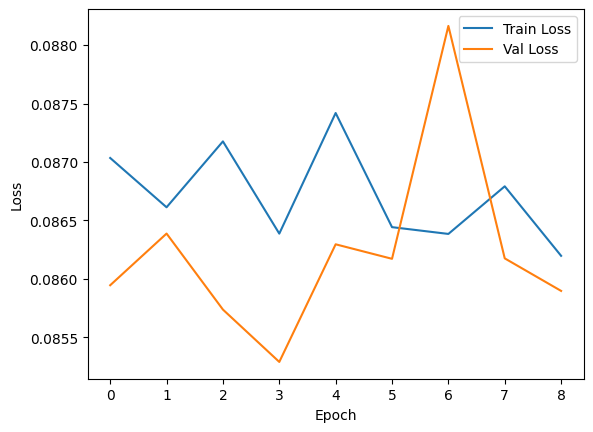

In [43]:
train_loss = fitting_sequential.history['loss']
val_loss = fitting_sequential.history['val_loss']
plt.plot(train_loss,label="Train Loss")
plt.plot(val_loss,label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

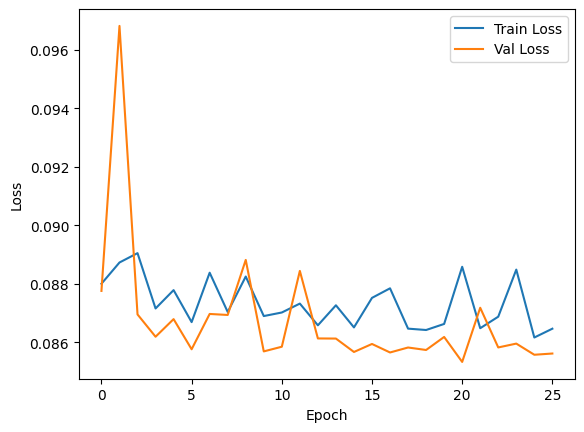

In [44]:
train_loss = fitting_functional.history['loss']
val_loss = fitting_functional.history['val_loss']
plt.plot(train_loss,label="Train Loss")
plt.plot(val_loss,label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Testing model

### Sequential

In [45]:
model.evaluate(test_ds)

601/601 [==============================] - 1s 2ms/step - loss: 0.0811 - accuracy: 0.9723 - precision: 0.9965 - recall: 0.6798 - auc: 0.9762


[0.08110982924699783,
 0.972282886505127,
 0.9964507818222046,
 0.6797820925712585,
 0.976168692111969]

### Functional

In [46]:
model_functional.evaluate(test_ds)

601/601 [==============================] - 1s 2ms/step - loss: 0.0822 - accuracy: 0.9718 - precision: 0.9719 - recall: 0.6913 - auc: 0.9758


[0.08221364766359329,
 0.9717628955841064,
 0.9719148874282837,
 0.6912832856178284,
 0.9757720232009888]

### untuk bagian hasil testing juga overall sama kedua model, mungkin akan terlihat berbeda di dataset yang lebih kompleks.
### Dari kedua model tersebut, hanya terlihat perbedaan di bagian recall dan precision
### precision pada Function API model lebih tinggi 1% dan recall dan AUC pada sequential model lebih tinggi 0.5%
### untuk metric lain seperti loss dan accuracy tidak terlihat perbedaan yang signifikan

### dari grafik visualisasi & hasil evaluasi, bisa dibilang model sudah berhasil memprediksi dengan cukup baik karena train loss dan val lossnya hampir mirip yang berarti merupakan sebuah good fit.